# Poisson equation

boundary value problem on $\textbf{x}\in\Omega$

$$\nabla^2 u = f(\textbf{x})$$

Dirichlet boundary condition on $\textbf{x}\in\partial\Omega_{\text{D}}$

$$u = u_{\text{D}}$$

Neumann boundary condition on $\textbf{x}\in\partial\Omega_{\text{N}}=\partial\Omega/\partial\Omega_{\text{D}}$

$$\textbf{n}\cdot\nabla{u} = u_{\text{N}}$$

variational formulation $\forall v\in V$

$$F(u, v)=-\int_\Omega\text{d}\Omega~\nabla v\cdot\nabla u + vf + \int_{\partial\Omega_{\text{N}}}\text{d}\Gamma~vu_{\text{N}}=0$$

In [1]:
from ufl.core.expr import Expr
from ufl import Form, inner, grad, dx, TestFunction, TrialFunction
from dolfinx.fem import FunctionSpace

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import bvp_solver, BoundaryConditions
from lucifex.viz import plot_colormap, plot_line
from lucifex.utils import cross_section


def poisson(
    u: Function,
    f: Function | Constant | Expr,
) -> tuple[Form, Form]:
    v = TestFunction(u.function_space)
    u_trial = TrialFunction(u.function_space)
    F_lhs = -inner(grad(v), grad(u_trial)) * dx
    F_rhs = -v * f * dx
    return F_lhs, F_rhs

## $d=2$ example  

$$\Omega = [0, L_x] \times [0, L_y]$$

$$f(x, y) = x + y^2$$

$$u(x,y=0)=0$$

$$u(x,y=1)=1$$

$$u(x=0,y)=y/L_y$$

$$\textbf{n}\cdot\nabla u\vert_{x=L_x,y}=y(L_y - y)$$

In [2]:
Lx = 2.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 20, 10)
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
        "lower": lambda x: x[1],
        "upper": lambda x: x[1] - Ly,
    },
)

fs = FunctionSpace(mesh, ('P', 1))
f = Function(fs, lambda x: x[0] + x[1] **2, name='f')

bcs = BoundaryConditions(
    ("dirichlet", boundary['lower'], 0.0),
    ("dirichlet", boundary['upper'], 1.0),  
    ("dirichlet", boundary['left'], lambda x: x[1] / Ly), 
    ("neumann", boundary["right"], lambda x: x[1] * (Ly - x[1])),
)
u = Function(fs, name='u')
u_solver = bvp_solver(poisson, bcs)(u, f)
u_solver.solve()

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$y$', ylabel='$u(x=0.50)$'>)

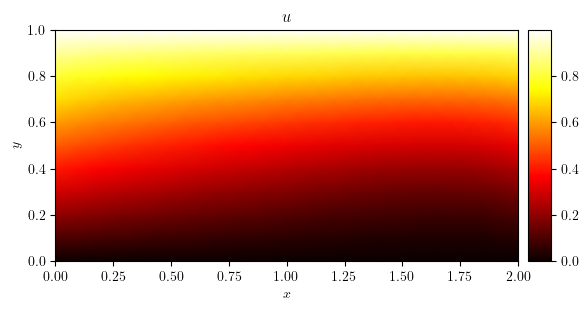

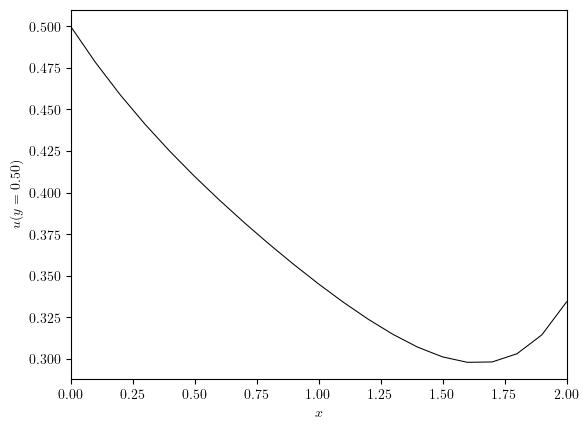

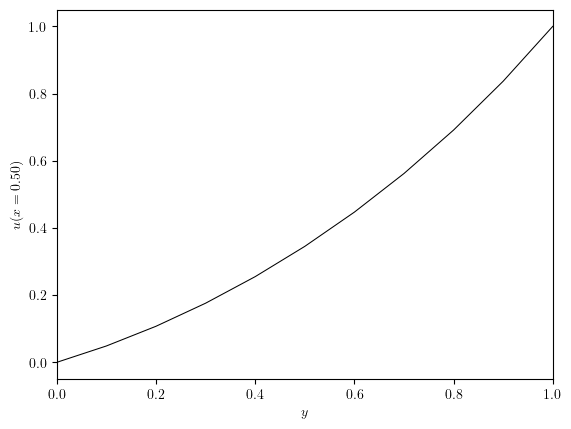

: 

In [ ]:
plot_colormap(u, title=f'${u.name}$')

x_axis, ux, y_value = cross_section(u, 'y', 0.5)
plot_line((x_axis, ux), x_label='$x$', y_label=f'${u.name}(y={y_value:.2f})$')

y_axis, uy, x_value = cross_section(u, 'x', 0.5)
plot_line((y_axis, uy), x_label='$y$', y_label=f'${u.name}(x={y_value:.2f})$')